In [34]:
import uproot
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import random

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [64]:
def getListFromString(listLike, numList = False): 
    #takes a string read from a csv or something and turns it into an actual list
    bracket1 = listLike.find('[')
    bracket2 = listLike[bracket1 + 1:].find(']') + bracket1 + 1
    listLike = listLike[bracket1+1:bracket2].split()
    for n,item in enumerate(listLike):
        listLike[n] = float(item)
    return listLike

In [65]:
def collapse(lst): #if all elements of a list are the same, collapse the list into a single item
    try:
        iter(lst) #checks if the item is a list
    except:
        return lst
    
    
    for n,i in enumerate(lst[:-1]):
        if i != lst[n+1]:
            return lst
    return lst[0]

In [89]:
metrics = pd.read_csv('metrics.csv')
metrics['Calculated Points'] = metrics['Calculated Points'].apply(getListFromString)
metrics['Calculated CFFs'] = metrics['Calculated CFFs'].apply(getListFromString)
metrics = metrics.drop(columns=metrics.columns[0])
metrics[['Epoch', 'Batch', 'Set']] = metrics[['Epoch', 'Batch', 'Set']].astype('int')
metrics[['MAE', "Max Residual", 'NRMSE']] = metrics[['MAE', "Max Residual", 'NRMSE']].astype('float64')
metrics

,Epoch,Batch,Set,Calculated Points,Calculated CFFs,MAE,Max Residual,NRMSE
0,1000,1,0,"[4.379068, 3.0256045, 1.984962, 1.3291527, 0.9...","[1.2335305, 1.9431615, 1.7685447, 0.04304915]",0.053502,0.441641,0.145107
1,1000,1,10,"[1.0699085, 0.6461129, 0.33125052, 0.13913009,...","[-0.48491034, 2.6451206, 1.544064, -0.17659155]",0.371229,1.070671,1.102310
2,1000,1,20,"[2.367971, 1.2501249, 0.7031766, 0.43974465, 0...","[0.48828804, 3.2438865, -0.46715337, 0.05110412]",0.016676,0.365862,0.150881
3,1000,1,30,"[0.03210824, 0.03121413, 0.02982204, 0.0280568...","[0.1854151, 2.7270494, 0.1649898, 0.00343999]",0.007239,0.011588,0.303606
4,1000,1,40,"[0.05017144, 0.0492326, 0.04777084, 0.04591788...","[0.11524266, 3.555745, 0.9095249, 0.02570893]",0.001347,0.006128,0.051253
...,...,...,...,...,...,...,...,...
10145,15000,46,300,"[-0.00708921, -0.0070824, -0.00707193, -0.0070...","[-2.2724557, 1.6408535, -1.7328175, -0.00725231]",0.007884,0.008478,8.916367
10146,15000,46,310,"[-0.00364462, -0.00365514, -0.00367216, -0.003...","[-2.0451174, 1.5644587, -1.6775113, -0.00534739]",0.005707,0.006590,3.204183
10147,15000,46,320,"[0.00380687, 0.00378846, 0.00375898, 0.0037200...","[-1.9595377, 1.5088271, -1.5228307, 0.0019028389]",0.001229,0.001949,0.630311
10148,15000,46,330,"[0.00331517, 0.00332221, 0.0033324, 0.00334385...","[-1.9641441, 1.5343705, -1.5577831, 0.0026148]",0.001523,0.002192,0.919918


In [90]:
actual_values = pd.read_csv('test_data/BKM_pseudodata2_with_CFFS.csv')
actual_values.rename(columns={"#Set":"Set"}, inplace=True)
actual_values['Set'] = actual_values['Set'].astype(int)
actual_values

,Set,index,k,QQ,x_b,t,phi_x,F,sigmaF,varF,F1,F2,ReH,ReE,ReHTilde,dvcs
0,1,0,2.75,1.51576,0.369204,-0.306885,8,4.193970,0.209699,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.020660
1,1,1,2.75,1.51576,0.369204,-0.306885,16,2.950900,0.147545,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.020660
2,1,2,2.75,1.51576,0.369204,-0.306885,24,1.865680,0.093284,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.020660
3,1,3,2.75,1.51576,0.369204,-0.306885,32,1.139000,0.056950,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.020660
4,1,4,2.75,1.51576,0.369204,-0.306885,40,0.871079,0.043554,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.020660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15385,342,40,24.00,6.04013,0.448435,-0.410593,328,0.001685,0.000084,0.05,0.465849,0.646508,1.245120,-2.14931,4.27622,0.001021
15386,342,41,24.00,6.04013,0.448435,-0.410593,336,0.001892,0.000095,0.05,0.465849,0.646508,1.245120,-2.14931,4.27622,0.001021
15387,342,42,24.00,6.04013,0.448435,-0.410593,344,0.002007,0.000100,0.05,0.465849,0.646508,1.245120,-2.14931,4.27622,0.001021
15388,342,43,24.00,6.04013,0.448435,-0.410593,352,0.001744,0.000087,0.05,0.465849,0.646508,1.245120,-2.14931,4.27622,0.001021


In [91]:
actual_values_listified = pd.DataFrame(columns = actual_values.columns)
for i in range(1,actual_values['Set'].max() + 1):
    tempdf = actual_values.query('Set==@i')
    tempdf = tempdf.stack().reset_index(level=0, drop=True)
    tempdf = tempdf.groupby(tempdf.index).apply(list).to_frame().transpose()
    actual_values_listified = pd.concat((actual_values_listified, tempdf), axis=0)
    
for column in actual_values_listified.columns:
    actual_values_listified[column] = actual_values_listified[column].apply(collapse)
actual_values = actual_values_listified
del actual_values_listified

In [92]:
overall = actual_values.merge(metrics, on='Set').drop(columns=['index','k','QQ','x_b','t','F1','F2','dvcs'])

In [95]:
overall.head()

,Set,phi_x,F,sigmaF,varF,ReH,ReE,ReHTilde,Epoch,Batch,Calculated Points,Calculated CFFs,MAE,Max Residual,NRMSE
0,10.0,"[8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...","[0.608777, 0.516947, 0.437611, 0.319228, 0.240...","[0.0304388, 0.0258474, 0.0218806, 0.0159614, 0...",0.05,1.30131,-2.20789,4.35799,1000,1,"[1.0699085, 0.6461129, 0.33125052, 0.13913009,...","[-0.48491034, 2.6451206, 1.544064, -0.17659155]",0.371229,1.070671,1.102310
1,10.0,"[8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...","[0.608777, 0.516947, 0.437611, 0.319228, 0.240...","[0.0304388, 0.0258474, 0.0218806, 0.0159614, 0...",0.05,1.30131,-2.20789,4.35799,1000,6,"[1.8701447, 1.2302101, 0.75490439, 0.46505871,...","[0.862003, 1.9643664, 1.0019683, -0.00459935]",0.108771,0.223735,0.296131
2,10.0,"[8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...","[0.608777, 0.516947, 0.437611, 0.319228, 0.240...","[0.0304388, 0.0258474, 0.0218806, 0.0159614, 0...",0.05,1.30131,-2.20789,4.35799,1000,11,"[2.1269228, 1.4566214, 0.95771253, 0.6521666, ...","[0.6644656, 0.05899979, -0.5481339, 0.1112022]",0.054142,0.211631,0.172883
3,10.0,"[8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...","[0.608777, 0.516947, 0.437611, 0.319228, 0.240...","[0.0304388, 0.0258474, 0.0218806, 0.0159614, 0...",0.05,1.30131,-2.20789,4.35799,1000,16,"[1.9700314, 1.3377498, 0.8672825, 0.5793327, 0...","[0.4930231, 0.9764898, -0.24991935, 0.07568005]",0.017459,0.123849,0.085335
4,10.0,"[8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...","[0.608777, 0.516947, 0.437611, 0.319228, 0.240...","[0.0304388, 0.0258474, 0.0218806, 0.0159614, 0...",0.05,1.30131,-2.20789,4.35799,1000,21,"[2.0789793, 1.4151264, 0.92125964, 0.6191033, ...","[0.7084602, 0.779871, -0.24031341, 0.09468135]",0.027370,0.170136,0.111763


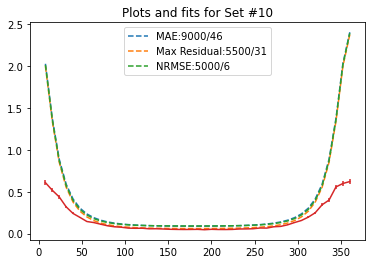

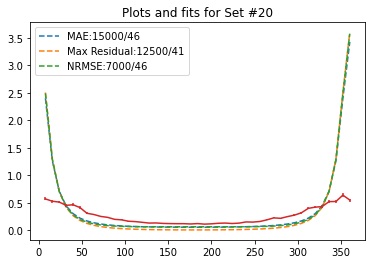

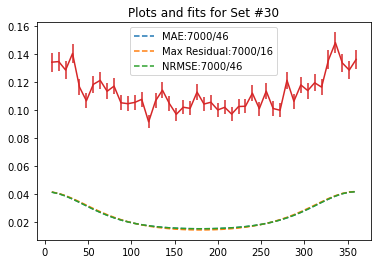

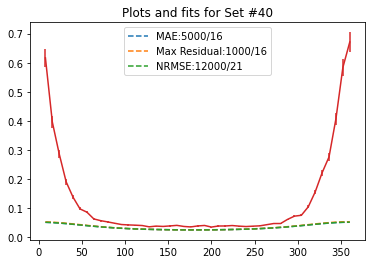

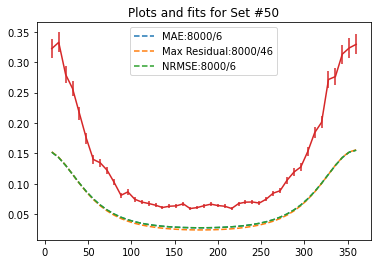

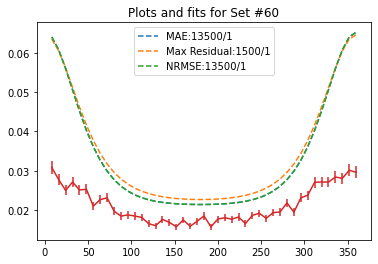

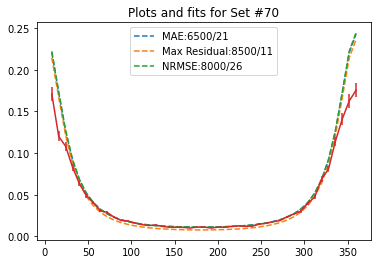

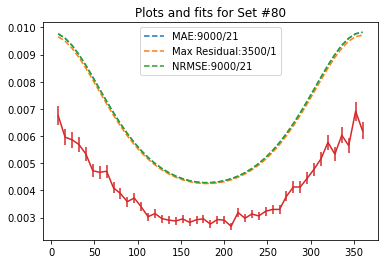

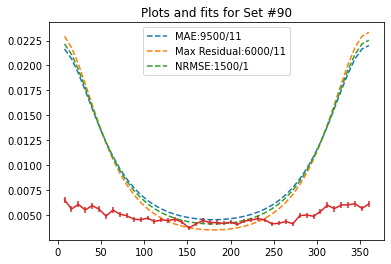

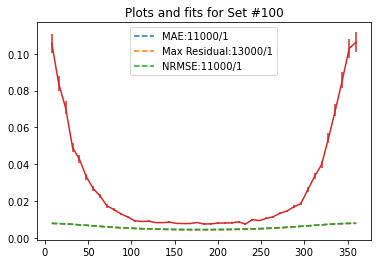

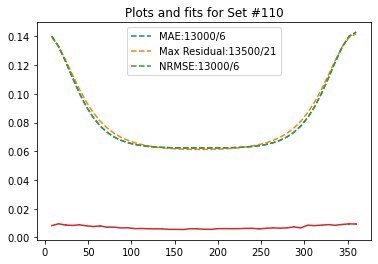

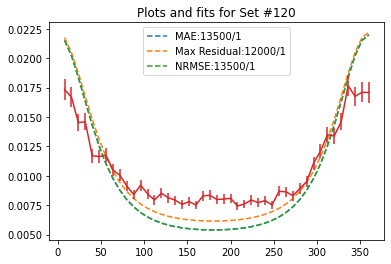

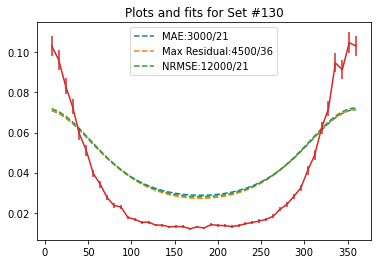

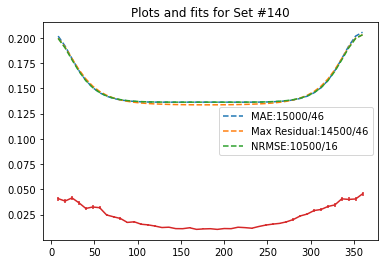

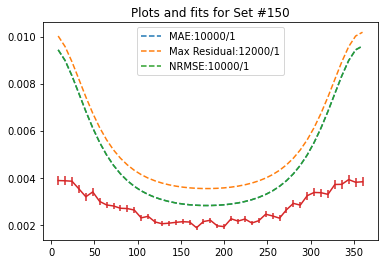

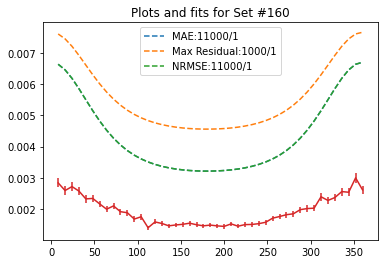

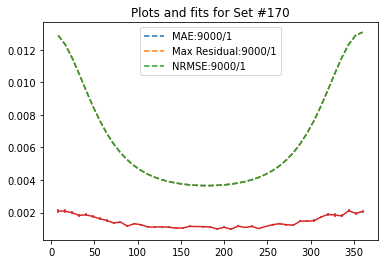

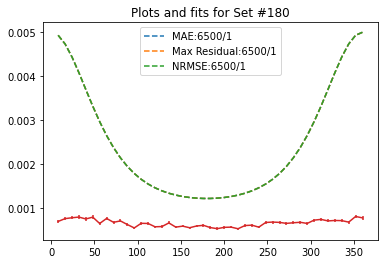

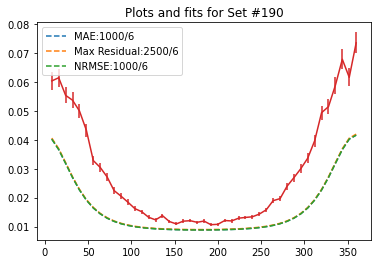

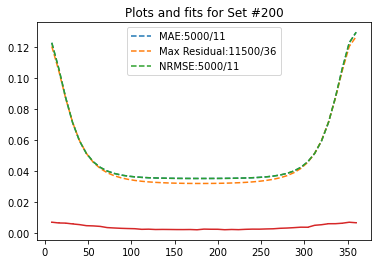

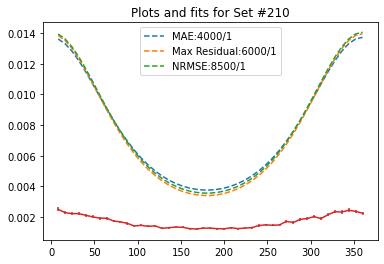

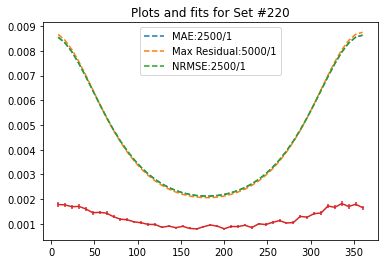

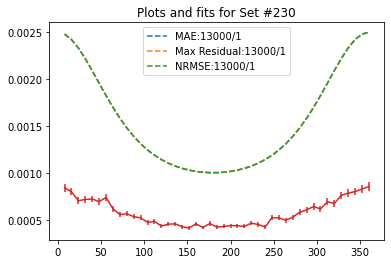

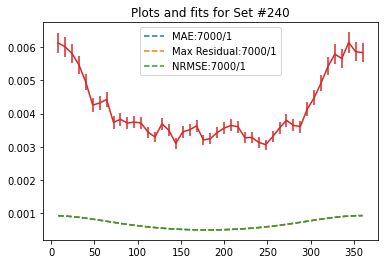

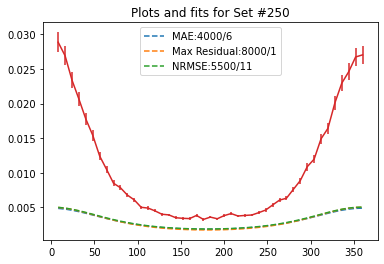

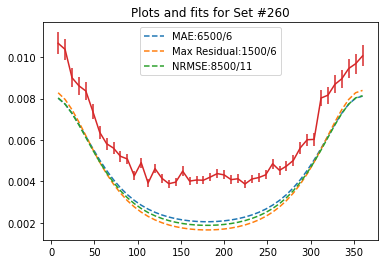

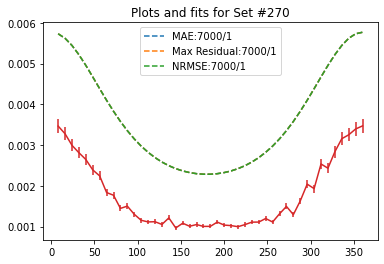

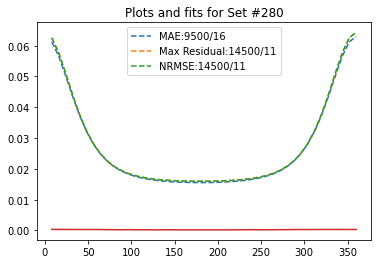

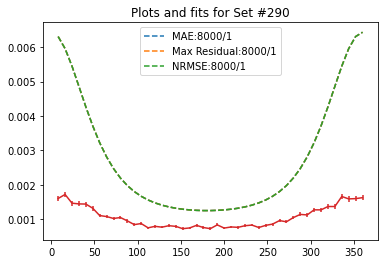

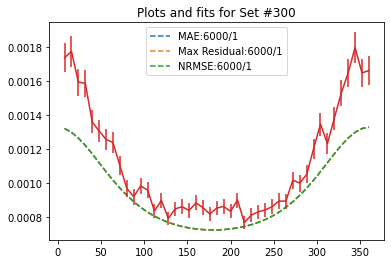

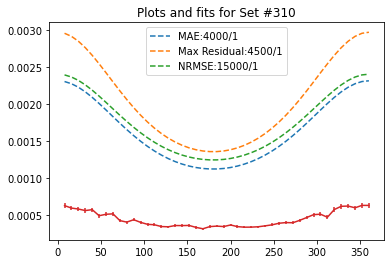

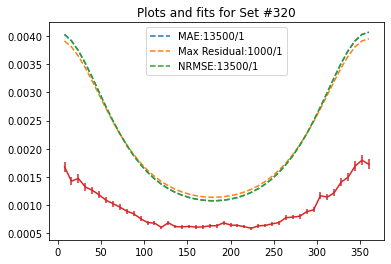

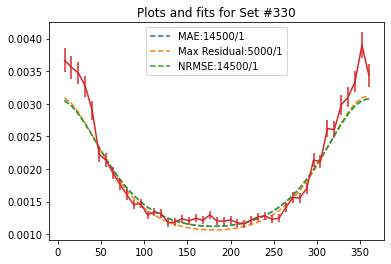

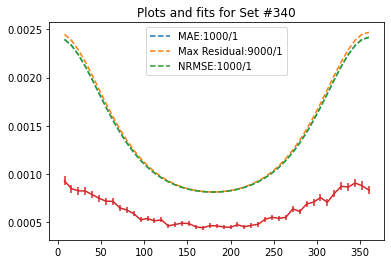

In [129]:
for i in np.arange(1, overall['Set'].max() + 1):
    tempdf = overall.query('Set==@i')
    
    if tempdf.empty:
        continue
    
    plt.figure();
    metric_values = [tempdf['MAE'].idxmin(), tempdf['Max Residual'].idxmin(), tempdf['NRMSE'].idxmin()]
    metric_names = ['MAE', 'Max Residual', 'NRMSE']
    
    for n, index in enumerate(metric_values):
        temprow = tempdf.loc[index]
        plt.plot(temprow['phi_x'], temprow['Calculated Points'], linestyle='dashed', 
                 label=metric_names[n] + ":" + str(temprow['Epoch']) + '/' + str(temprow["Batch"]));
    plt.errorbar(temprow['phi_x'], temprow['F'], yerr=temprow['sigmaF']);
    plt.title('Plots and fits for Set #' + str(int(i)));
    plt.legend();

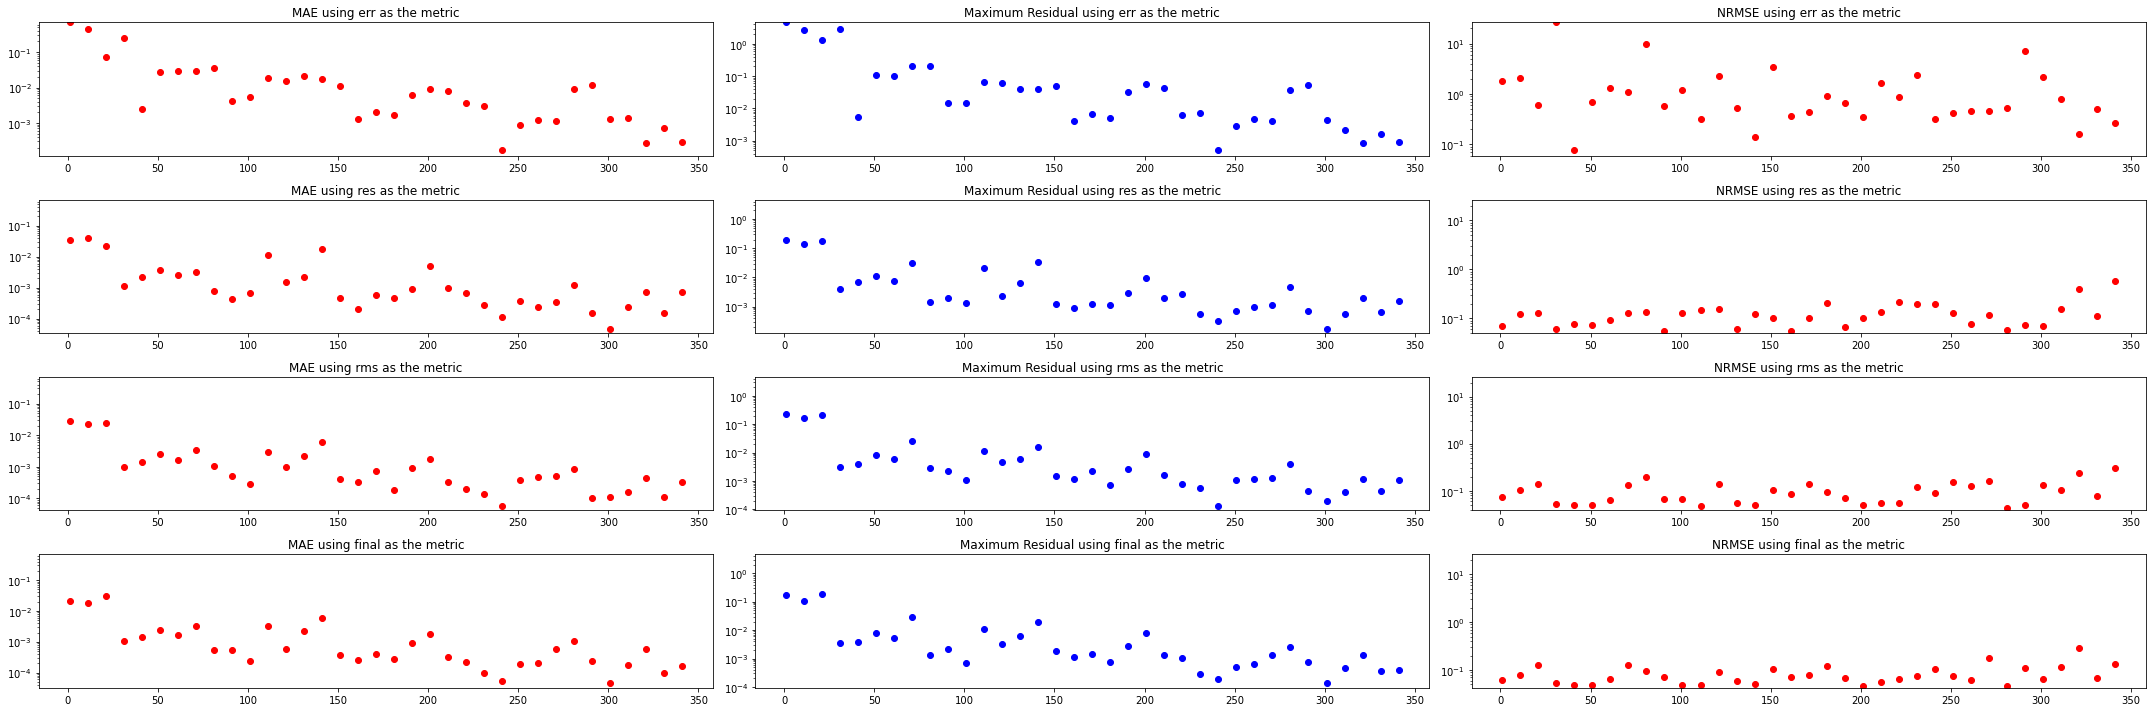

In [3]:
fig, ax = plt.subplots(4,3, figsize=(30,10));

errList = resList = rmsList = overallList = []

mappings = {'err':0,'res':1,'rms':2,'final':3}

for index,row in metrics.iterrows():
    
    ax[ mappings[ row['designator'] ] ][0].scatter(row['set'], row['err'], c='r')
    ax[ mappings[ row['designator'] ] ][0].set_title('MAE using ' + row['designator'] + ' as the metric')
    ax[ mappings[ row['designator'] ] ][0].set_yscale('log')
    
    ax[ mappings[ row['designator'] ] ][1].scatter(row['set'], row['res'], c='b')
    ax[ mappings[ row['designator'] ] ][1].set_title('Maximum Residual using ' + row['designator'] + ' as the metric')
    ax[ mappings[ row['designator'] ] ][1].set_yscale('log')
    
    ax[ mappings[ row['designator'] ] ][2].scatter(row['set'], row['rms'], c='r')
    ax[ mappings[ row['designator'] ] ][2].set_title('NRMSE using ' + row['designator'] + ' as the metric')
    ax[ mappings[ row['designator'] ] ][2].set_yscale('log')
    
for i in ax:
    i[0].set_ylim(top=metrics['err'].max())
    i[1].set_ylim(top=metrics['res'].max())
    i[2].set_ylim(top=metrics['rms'].max())
    
plt.tight_layout();

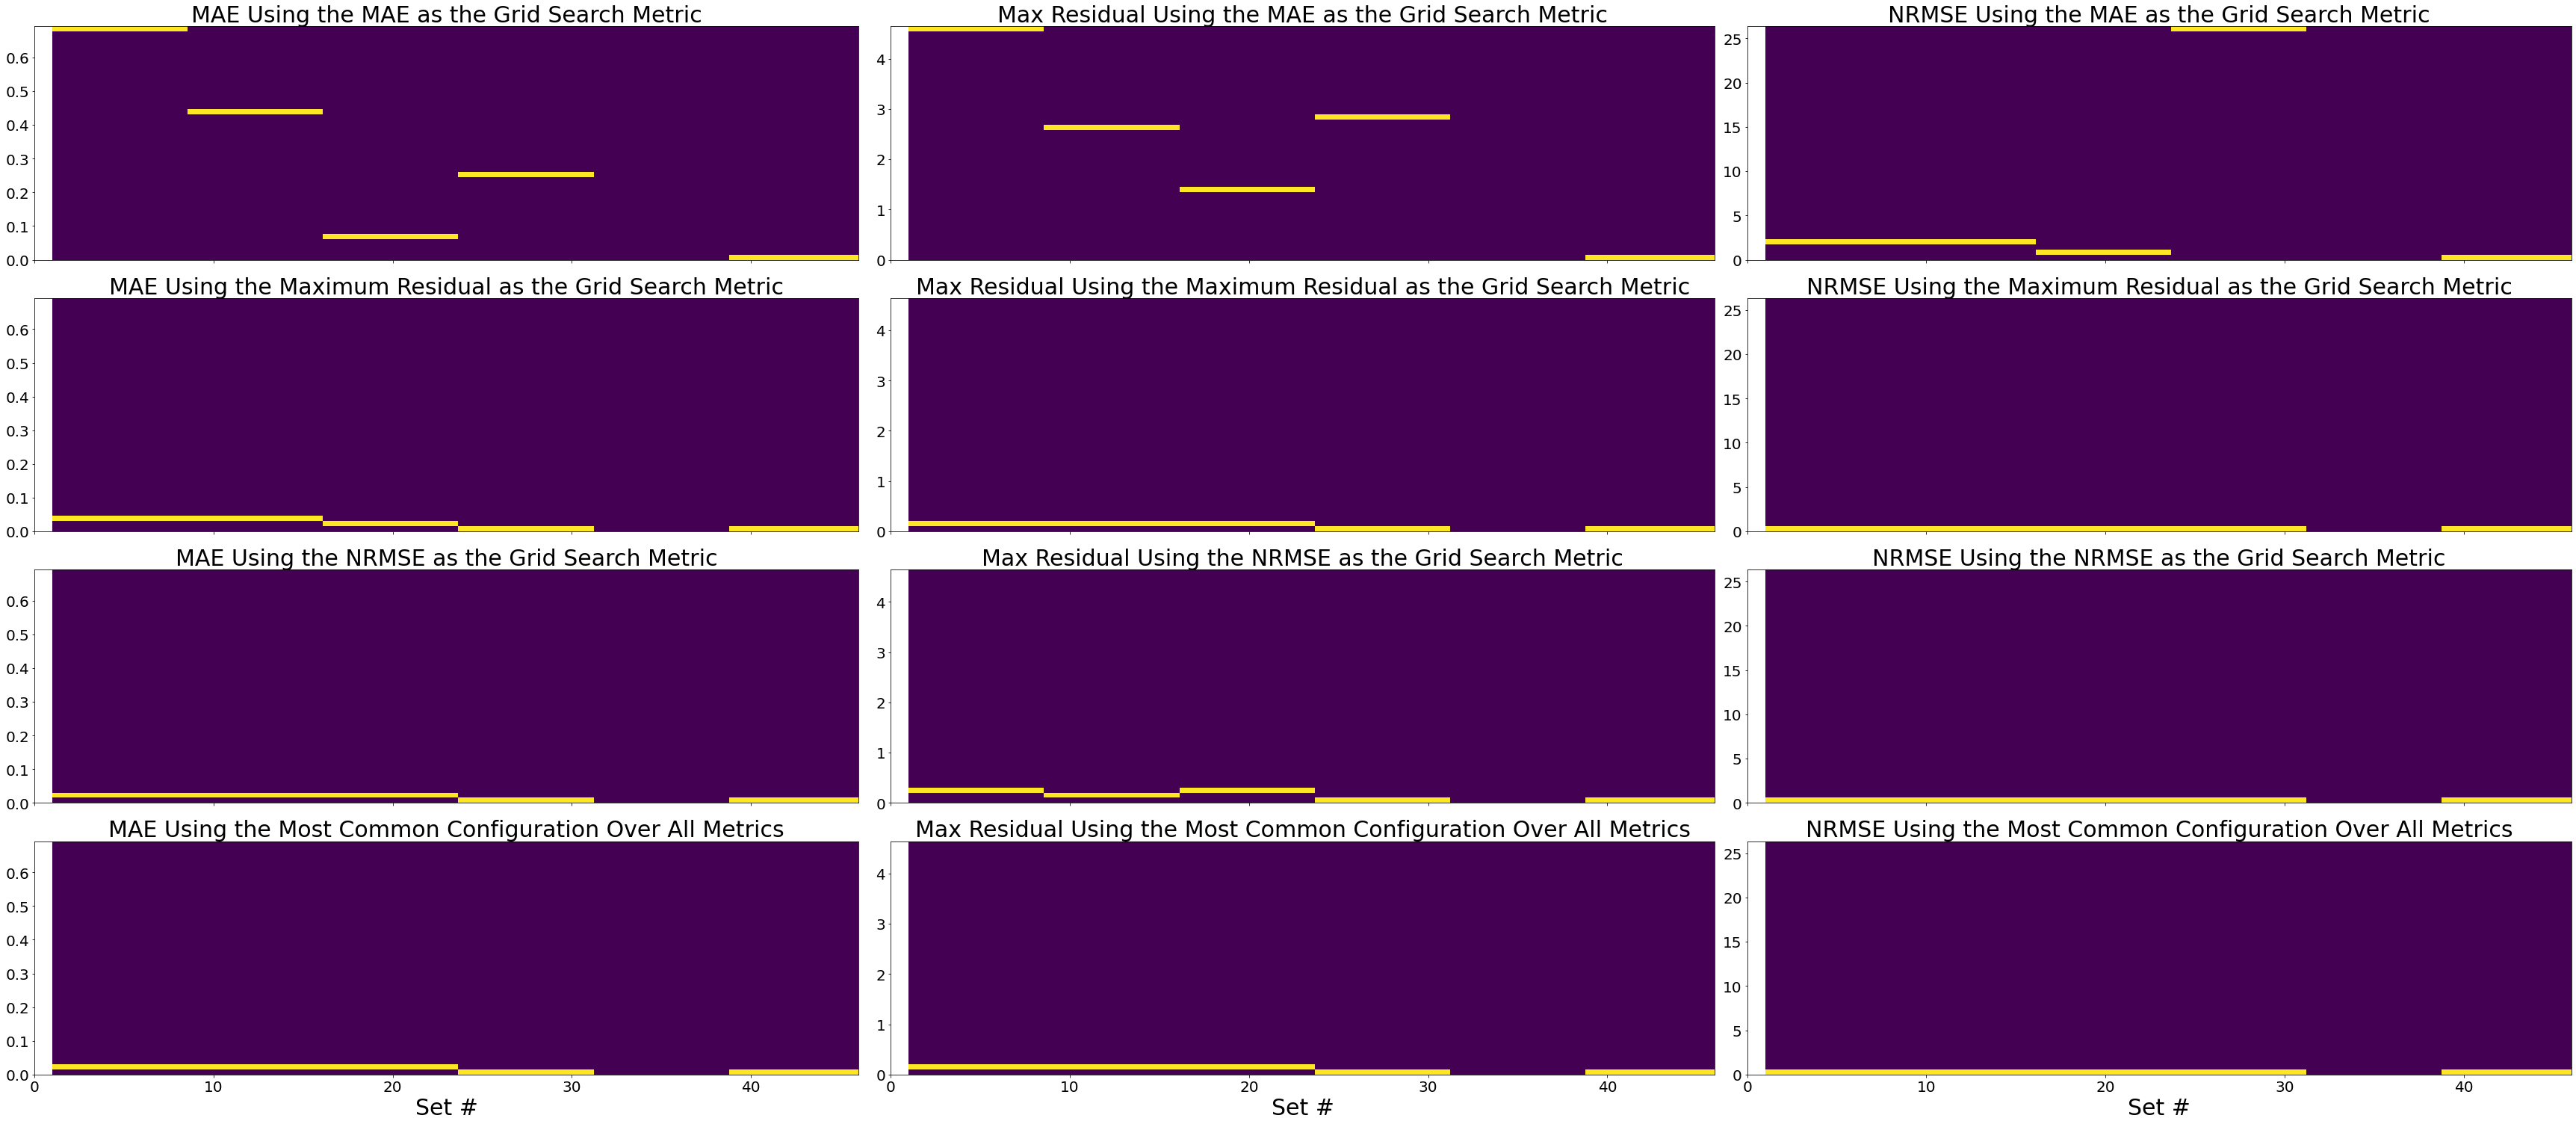

In [9]:
boundaryColors = ['cyan', 'lime', 'yellow', 'pink']
fig, axs = plt.subplots(4,3, figsize=(12*4,7*3), sharex=True);
row = 0

for n,metric in enumerate(metrics.columns[2:]):
    for j,designator in enumerate(mappings.keys()):
        df_masked = metrics[metrics.designator == designator];
        
        histo = axs[j][n].hist2d(df_masked.set,
                                 df_masked[metric], 
                                 range=((1, metrics['set'].max()),(0, metrics[metric].max())), 
                                 bins=45);
#         fig.colorbar(histo[3], ax=axs[j][n]);
        
        axs[j][n].set_ylim(top=metrics[metric].max(), bottom=0);
        axs[j][n].set_xlim(left=0, right=46);
        title = ""
        ylabel = ""
        if metric == 'err':
            title += "MAE Using "
            ylabel = "MAE"
        elif metric == 'res':
            title += "Max Residual Using "
            ylabel = "Max Residual"
        elif metric == 'rms':
            title += "NRMSE Using "
            ylabel = "NRMSE"
        
        if designator == 'err':
            title += "the MAE as the Grid Search Metric"
        elif designator == 'res':
            title += "the Maximum Residual as the Grid Search Metric"
        elif designator == 'rms':
            title += "the NRMSE as the Grid Search Metric"
        else:
            title += "the Most Common Configuration Over All Metrics"
            
        axs[j][n].set_title(title, fontsize=30);
        axs[j][n].tick_params(axis='both', labelsize=20);
#         axs[j][n].set_ylabel(ylabel, fontsize=30);
        if j == 3:
            axs[j][n].set_xlabel("Set #", fontsize=30);
        
#         axs[j][n].set_yscale('log');
fig.tight_layout()

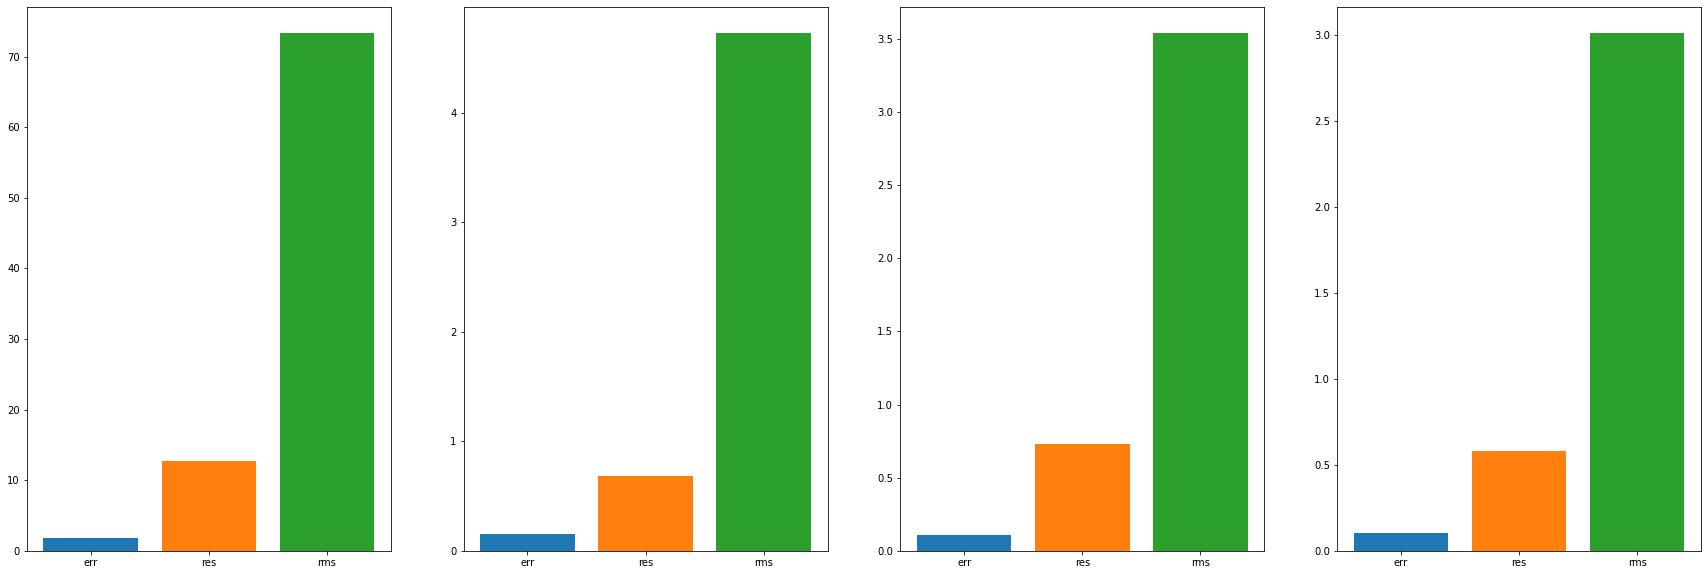

In [10]:
fig, ax = plt.subplots(1,4, figsize=(30,10));
for x_axis_element in metrics.columns[2:]:
    for n,designator in enumerate(mappings.keys()):
        ax[n].bar(x_axis_element, np.sum(metrics[metrics.designator == designator][x_axis_element]));

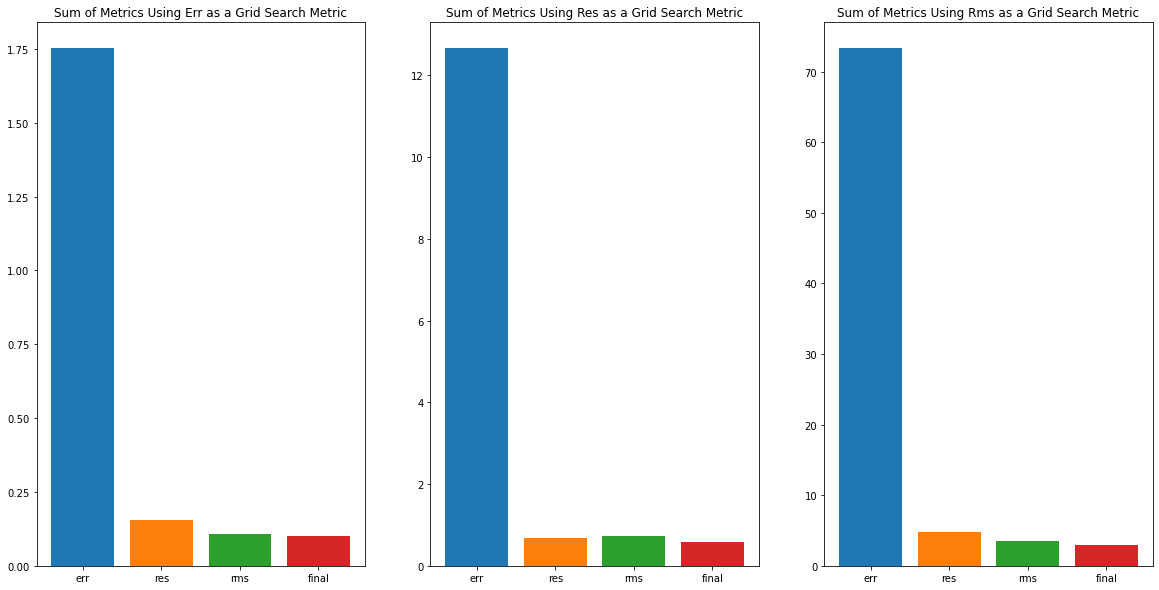

In [27]:
fig, ax = plt.subplots(1,3,figsize=(20,10));
for designator in mappings.keys():
    for n,metric in enumerate(metrics.columns[2:]):
        ax[n].bar(designator, np.sum(metrics[metrics.designator == designator][metric]));
        ax[n].set_title('Sum of Metrics Using ' + metric.title() + ' as a Grid Search Metric')

In [28]:
MAE_combinations = pd.read_csv('best_combination_errors.csv', names=['Set#', '#epochs', "batch#", "metric_value"])
MAE_combinations
MAE_combinations['metric'] = 'MAE'
RES_combinations = pd.read_csv('best_combination_residual.csv', names=['Set#', '#epochs', "batch#", "metric_value"])
RES_combinations['metric'] = 'RES'
NRMSE_combinations= pd.read_csv('best_combination_rms.csv', names=['Set#', '#epochs', "batch#", "metric_value"])
NRMSE_combinations['metric'] = 'NRMSE'

best_combos = pd.concat([MAE_combinations, RES_combinations, NRMSE_combinations]).dropna()
best_combos[['Set#','#epochs','batch#']] = best_combos[['Set#','#epochs','batch#']].astype(int)
best_combos

,Set#,#epochs,batch#,metric_value,metric
1,0,5700,31,0.021075848711013805,MAE
2,20,8000,31,0.015453191243033933,MAE
3,40,10400,21,0.001248928682117462,MAE
4,60,9800,11,0.0015665820018651755,MAE
5,80,2200,11,0.00025812240953561994,MAE
6,100,9800,21,0.00022439623420405393,MAE
7,120,9200,1,0.0004282140077085758,MAE
8,140,11200,31,0.005826888096321957,MAE
9,160,1500,21,0.00017764512574696542,MAE
10,180,2200,6,0.00010300644837321174,MAE


In [29]:
best_combos.query('metric=="MAE"')

,Set#,#epochs,batch#,metric_value,metric
1,0,5700,31,0.021075848711013805,MAE
2,20,8000,31,0.015453191243033933,MAE
3,40,10400,21,0.001248928682117462,MAE
4,60,9800,11,0.0015665820018651755,MAE
5,80,2200,11,0.00025812240953561994,MAE
6,100,9800,21,0.00022439623420405393,MAE
7,120,9200,1,0.0004282140077085758,MAE
8,140,11200,31,0.005826888096321957,MAE
9,160,1500,21,0.00017764512574696542,MAE
10,180,2200,6,0.00010300644837321174,MAE


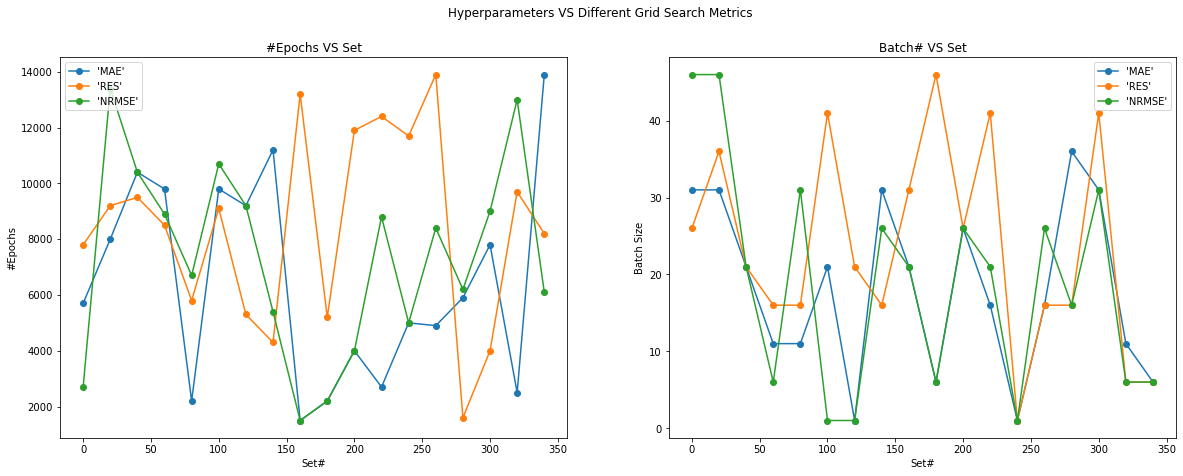

In [30]:
metricsList = ["'MAE'", "'RES'", "'NRMSE'"]
fig, ax = plt.subplots(1,2,figsize=(20,7))
for metric in metricsList:
    intermediate_df = best_combos.query('metric=='+metric)
    ax[0].plot(intermediate_df['Set#'], intermediate_df['#epochs'], marker='o', label=metric)
    ax[1].plot(intermediate_df['Set#'], intermediate_df['batch#'], marker='o', label=metric)

ax[0].set_title('#Epochs VS Set');
ax[0].set_xlabel('Set#');
ax[0].set_ylabel('#Epochs');
# ax[0].set_xticks([0,1,2,3,4], fontsize=20);

ax[1].set_title('Batch# VS Set');
ax[1].set_xlabel('Set#');
ax[1].set_ylabel('Batch Size');
# ax[1].set_xticks([0,1,2,3,4], fontsize=20);

fig.suptitle('Hyperparameters VS Different Grid Search Metrics');


ax[0].legend();
ax[1].legend();

In [77]:
actual_values = pd.read_csv('test_data/BKM_pseudodata2_with_CFFS.csv')#[
#     ["phi_x","F", "sigmaF", "varF", "ReH", "ReE", "ReHTilde"]
# ]
actual_values.rename(columns={"#Set":"Set"}, inplace=True)
fitted_values = pd.read_csv('bySetCFFs.csv')
fitted_values.columns = ['toDrop', 'set', 'designation', 'ReH', 'ReE', 'ReHTilde', 'const']
fitted_values.drop(columns=['toDrop'], inplace=True)

In [78]:
fitted_values

,set,designation,ReH,ReE,ReHTilde,const
0,0,err,0.686438,1.324868,1.910560,0.052736
1,0,res,0.753782,0.927845,1.185287,0.021278
2,0,rms,0.183858,0.135916,0.405936,0.038182
3,0,final,0.303046,0.580978,1.011594,0.033192
4,10,err,0.984380,0.644800,1.087952,0.091035
...,...,...,...,...,...,...
135,330,final,0.887433,1.782022,0.656160,0.001053
136,340,err,1.522721,2.119414,1.128180,0.000771
137,340,res,-3.513409,-6.049349,-0.775860,0.000872
138,340,rms,-1.423621,-1.305274,-0.236316,0.000655


In [75]:
actual_values.query('Set==1')

,Set,index,k,QQ,x_b,t,phi_x,F,sigmaF,varF,F1,F2,ReH,ReE,ReHTilde,dvcs
0,1,0,2.75,1.51576,0.369204,-0.306885,8,4.193970,0.209699,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
1,1,1,2.75,1.51576,0.369204,-0.306885,16,2.950900,0.147545,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
2,1,2,2.75,1.51576,0.369204,-0.306885,24,1.865680,0.093284,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
3,1,3,2.75,1.51576,0.369204,-0.306885,32,1.139000,0.056950,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
4,1,4,2.75,1.51576,0.369204,-0.306885,40,0.871079,0.043554,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
5,1,5,2.75,1.51576,0.369204,-0.306885,48,0.640750,0.032037,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
6,1,6,2.75,1.51576,0.369204,-0.306885,56,0.474527,0.023726,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
7,1,7,2.75,1.51576,0.369204,-0.306885,64,0.391808,0.019590,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
8,1,8,2.75,1.51576,0.369204,-0.306885,72,0.293337,0.014667,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066
9,1,9,2.75,1.51576,0.369204,-0.306885,80,0.256715,0.012836,0.05,0.542867,0.798677,0.743515,-1.58545,3.34929,0.02066


In [106]:
total_errors = {}
total_residuals = {}
total_rms_vals = {}
F = {}

for epoch in np.arange(1000, 1500, 100):
    for batch in np.arange(1,47,5):
        for i in np.arange(0,20,5):
            F[(epoch, batch, i)] = [random.uniform(0,100) for i in range(10)]
            total_errors[(epoch, batch, i)] = random.uniform(0,100)
            total_residuals[(epoch, batch, i)] = random.uniform(0,100)
            total_rms_vals[(epoch, batch, i)] = random.uniform(0,100)

In [107]:
total_errors = pd.Series(total_errors).reset_index()
total_errors.columns = ["epoch", "batch", "set", "MAE"]

total_residuals = pd.Series(total_residuals).reset_index()
total_residuals.columns = ["epoch", "batch", "set", "Max Residual"]

total_rms_vals = pd.Series(total_rms_vals).reset_index()
total_rms_vals.columns = ["epoch", "batch", "set", "NRMSE"]

In [108]:
total_errors.merge(total_residuals).merge(total_rms_vals)

,epoch,batch,set,MAE,Max Residual,NRMSE
0,1000,1,0,98.416297,55.075529,74.424959
1,1000,1,5,99.666027,72.728884,45.268496
2,1000,1,10,70.246003,50.705402,92.421913
3,1000,1,15,91.891456,99.035053,53.969920
4,1000,6,0,74.634006,94.498901,27.102506
...,...,...,...,...,...,...
195,1400,41,15,65.898105,68.699102,2.012921
196,1400,46,0,46.432586,28.589453,60.916011
197,1400,46,5,81.881409,85.954353,10.817484
198,1400,46,10,9.385221,57.896286,3.981944
